# Trains a CNN-LSTM model on a subset of UCF_50 dataset.

In [1]:
!nvidia-smi

Tue Apr 27 19:07:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
colab = True
if colab:
    # Mount drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # Set path to working directory
    import sys
    sys.path.append('/content/gdrive/My Drive/ImageCLEF2021/')
    %cd /content/gdrive/My\ Drive/ImageCLEF2021/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/ImageCLEF2021


In [4]:
# !pip install -U --pre tensorflow=="2.2.0" -q

In [5]:
# function ClickConnect(){
# console.log("Working");
# document.querySelector("colab-toolbar-button#connect").click()
# }setInterval(ClickConnect,60000)

In [7]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score


ROOT_DIR = os.path.abspath("./")
CFG_NAME = "eb3_ucf"
LOG_PATH = os.path.join(ROOT_DIR, "logs", CFG_NAME)

DATASET_PATH = os.path.join(ROOT_DIR, "dataset/UCF50_subset")

# Make logs directory, dump all experiment results inside this sub folder
if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))

# Make new directory for the current experiment
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)


data_dir = DATASET_PATH
img_height , img_width = 224, 224
seq_len = 70

#classes = ["Basketball", "HighJump", "GolfSwing", "HorseRace", "Kayaking", "Skiing"]
classes = ['Mixing',
 'TennisSwing',
 'HorseRiding',
 'JumpRope',
 'JumpingJack',
 'BaseballPitch',
 'Rowing',
 'SkateBoarding',
 'WalkingWithDog',
 'Skijet']

num_classes = len(classes)

def compute_accuray_kappa_score(y1, y2):
    """Computes acc and kappa scores
    y1 : (N,) shape of labels
    y2 : (N,) shape of predicted labels
    """
    # Accuracy
    acc = accuracy_score(y1, y2) * 100
    print("Accuracy : {:.3f}".format(acc)) 

    # Kappa 
    # -1 to 1, 1 means complete agreement
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html
    # https://stackoverflow.com/questions/43676905/how-to-calculate-cohens-kappa-coefficient-that-measures-inter-rater-agreement
    kappa = cohen_kappa_score(y1, y2)
    print("Kappa Score : {:.3f}".format(kappa))


def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    #plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}/{}_loss.jpg'.format(LOG_PATH, CFG_NAME), dpi=100)
    plt.show()

    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    #plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}/{}_acc.jpg'.format(LOG_PATH, CFG_NAME), dpi=100)
    plt.show()


def plot_slices(num_rows, num_columns, width, height, channels, video):
    """Plot a montage of slices"""
    data = video.copy()
    #data = np.rot90(np.array(data))
    #data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height, channels))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    ct = 1
    for i in range(rows_data):
        for j in range(columns_data):
            font = cv2.FONT_HERSHEY_COMPLEX  #press tab for different operations
            img = np.dstack((data[i][j], data[i][j], data[i][j]))
            img = cv2.resize(img, (64, 64))
            cv2.putText(img, str(ct), (3,15), font, 0.5, (0,255,0), 1, cv2.LINE_AA)
            axarr[i, j].imshow(img, cmap="gray")
            axarr[i, j].axis("off")
            ct+=1
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


#  Creating frames from videos
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
    while count <= seq_len: 
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            # Convert to grayscale
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
    return frames_list
 
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = classes # or use os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [8]:
# Create numpy array of data, this was done locally
# X, Y = create_data(data_dir)
# print(X.shape, Y.shape)

# np.save("{}/x.npy".format(DATASET_PATH), X)
# np.save("{}/y.npy".format(DATASET_PATH), Y)

In [9]:
X = np.load("{}/ucf10_videos.npy".format(DATASET_PATH))
Y = np.load("{}/ucf10_labels.npy".format(DATASET_PATH))
X = np.expand_dims(X, axis=4)
print(X.shape, Y.shape)

(1366, 70, 224, 224, 1) (1366, 10)


In [10]:
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=seed)
X, Y = None, None
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1092, 70, 224, 224, 1) (274, 70, 224, 224, 1) (1092, 10) (274, 10)


Video of JumpingJack.


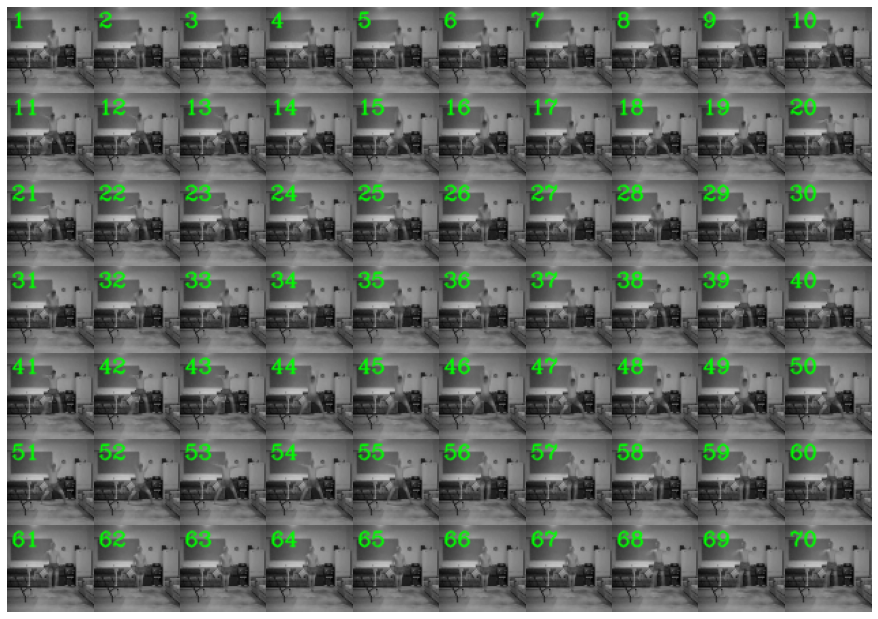

In [11]:
# Visualize montage of slices.
ct = 200
idx = np.argmax(y_train[ct])
print("Video of {}.".format(classes[idx]))
plot_slices(7, 10, 224, 224, 1, X_train[ct])

### Models

In [12]:
def convlstm():
  """Stupid model"""
  seq_len, img_height, img_width = 70, 64, 64
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 1)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(6, activation = "softmax"))
  # Compile model
  optimizer = tf.keras.optimizers.SGD(lr=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  return model


def vgg_lstm():
  """Somewhat better"""
  # define input D, W, H, 1
  video = tf.keras.layers.Input(shape=(seq_len,
                      img_height,
                      img_width,
                      1))
  
  # map N channels data to 3 channels for input to CNN
  layer_3d = tf.keras.layers.Conv3D(3, (1, 1, 1))(video) 

  # define base model for feature extraction
  # cnn_base = tf.keras.applications.VGG16(input_shape=(img_height,
  #                               img_width,
  #                               3),
  #                 weights="imagenet",
  #                 include_top=False)
  cnn_base = tf.keras.applications.EfficientNetB3(input_shape=(img_height,
                                img_width,
                                3),
                  weights="imagenet",
                  include_top=False)
  
  cnn_out = tf.keras.layers.GlobalAveragePooling2D()(cnn_base.output)
  cnn = tf.keras.Model(inputs=cnn_base.input, outputs=cnn_out)
  cnn.trainable = False

  # video frames go through cnn and then to lstm
  encoded_frames = tf.keras.layers.TimeDistributed(cnn)(layer_3d)
  print(encoded_frames)
  encoded_sequence = tf.keras.layers.LSTM(256)(encoded_frames)
  hidden_layer = tf.keras.layers.Dense(1024, activation="relu")(encoded_sequence)
  outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(hidden_layer)
  model = tf.keras.Model([video], outputs)

  optimizer = tf.keras.optimizers.SGD(lr=0.001)
  # optimizer = tf.keras.optimizers.Nadam(lr=0.002,
  #                   beta_1=0.9,
  #                   beta_2=0.999,
  #                   epsilon=1e-08,
  #                   schedule_decay=0.004)
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
  return model

def vgg_lstm_4096():
  """More better, maybe? Test it out.
  Try GRUs next.
  """
  # define input D, W, H, 1
  video = tf.keras.layers.Input(shape=(seq_len,
                      img_height,
                      img_width,
                      1))
  
  # map N channels data to 3 channels for input to CNN
  layer_3d = tf.keras.layers.Conv3D(3, (1, 1, 1))(video) 
  # define base model for feature extraction
  cnn_base = tf.keras.applications.VGG16(input_shape=(img_height,
                                img_width,
                                3),
                  weights="imagenet",
                  include_top=True) # set to True, when using 4096-d f.v
  cnn = tf.keras.Model(inputs=cnn_base.input, outputs=cnn_base.layers[-3].output)
  cnn.trainable = False
  
  # video frames go through cnn and then to lstm
  encoded_frames = tf.keras.layers.TimeDistributed(cnn)(layer_3d)
  print(encoded_frames)
  encoded_sequence = tf.keras.layers.LSTM(256)(encoded_frames)
  hidden_layer = tf.keras.layers.Dense(1024, activation="relu")(encoded_sequence)
  outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(hidden_layer)
  model = tf.keras.Model([video], outputs)
  optimizer = tf.keras.optimizers.Nadam(lr=0.002,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-08,
                    schedule_decay=0.004)
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
  return model

### Compile and train

43941888/43941136 [==============================] - 2s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 70, 1536), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 224, 224, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 70, 224, 224, 3)   6         
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 1536)          10783535  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               1836032   
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________

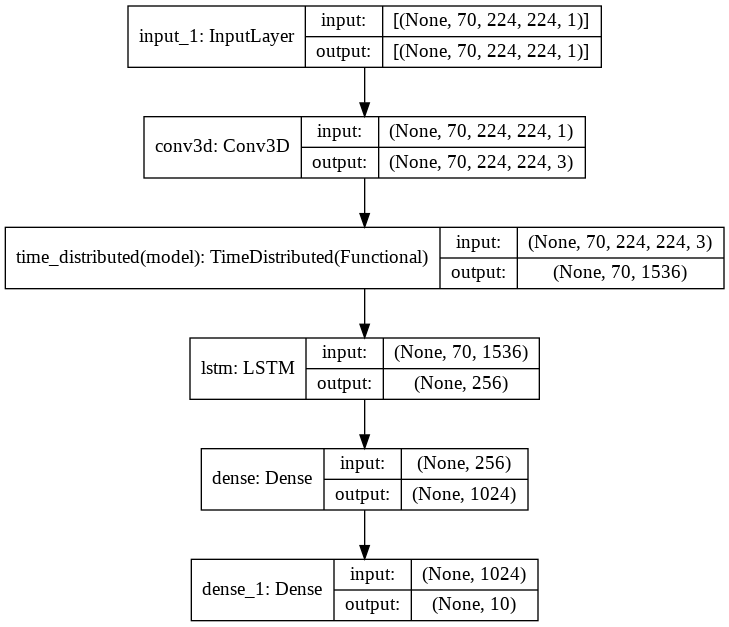

In [13]:
# Callbacks
earlystop = tf.keras.callbacks.EarlyStopping(patience=8,
                          verbose=1,
                          restore_best_weights=True)
csv = tf.keras.callbacks.CSVLogger('{}/{}_training.csv'.format(LOG_PATH, CFG_NAME))
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.1, 
                                             verbose=1, 
                                             patience=5, 
                                             mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="{}/{}.h5".format(LOG_PATH, CFG_NAME),
                                            monitor='val_loss',
                                            mode='min',
                                            verbose=1,
                                            save_best_only=True)
callbacks = [earlystop, reducelr, checkpoint, csv]

# Create model
model = None
model = vgg_lstm()
print(model.summary())
tf.keras.utils.plot_model(model, to_file='{}/model_plot.png'.format(LOG_PATH), show_shapes=True, show_layer_names=True)

Training model.
Epoch 1/100
873/873 [==============================] - 268s 289ms/step - loss: 2.1764 - accuracy: 0.3135 - val_loss: 1.7216 - val_accuracy: 0.6758

Epoch 00001: val_loss improved from inf to 1.72159, saving model to /content/gdrive/My Drive/ImageCLEF2021/logs/eb3_ucf/eb3_ucf.h5
Epoch 2/100
873/873 [==============================] - 248s 284ms/step - loss: 1.5221 - accuracy: 0.7031 - val_loss: 1.1233 - val_accuracy: 0.8174

Epoch 00002: val_loss improved from 1.72159 to 1.12334, saving model to /content/gdrive/My Drive/ImageCLEF2021/logs/eb3_ucf/eb3_ucf.h5
Epoch 3/100
873/873 [==============================] - 248s 284ms/step - loss: 0.9195 - accuracy: 0.8496 - val_loss: 0.6886 - val_accuracy: 0.8995

Epoch 00003: val_loss improved from 1.12334 to 0.68860, saving model to /content/gdrive/My Drive/ImageCLEF2021/logs/eb3_ucf/eb3_ucf.h5
Epoch 4/100
873/873 [==============================] - 248s 284ms/step - loss: 0.4973 - accuracy: 0.9398 - val_loss: 0.4527 - val_accuracy:

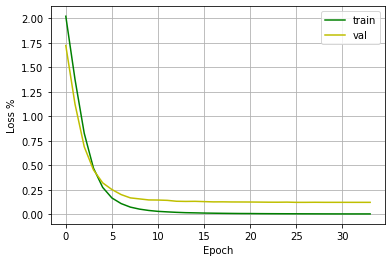

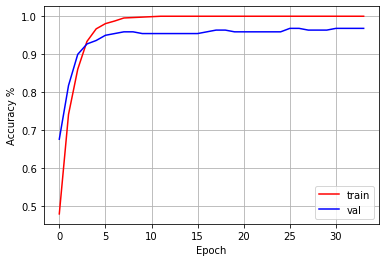

In [14]:
# Train
print("Training model.")
history = model.fit(x = X_train, y = y_train, 
                    callbacks=callbacks,
                    epochs=100, 
                    batch_size = 1, 
                    shuffle=True, 
                    validation_split=0.2 
                    )
plot_loss_accu(history)

### Test

In [15]:
from tensorflow.keras.models import load_model

model = None
model = load_model("{}/{}.h5".format(LOG_PATH, CFG_NAME), compile = False)
model.summary()

# Run prediction
y_pred = []
print("Running predictions on test set.")
for x in X_test:
  y_pred.append(model.predict(np.expand_dims(x, axis=0)))
y_pred = np.array(y_pred)
y_pred = np.squeeze(y_pred)

# Flatten
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
assert y_pred.shape == y_test.shape, "Should be same!"

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 224, 224, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 70, 224, 224, 3)   6         
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 1536)          10783535  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               1836032   
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 12,892,991
Trainable params: 2,109,456
Non-trainable params: 10,783,535
_______________________________________

In [16]:
%%capture cap --no-stderr
compute_accuray_kappa_score(y_test, y_pred)
print("\n")
print(classification_report(y_test, y_pred))

In [17]:
with open('{}/test_results.txt'.format(LOG_PATH), 'w') as f:
    f.write(cap.stdout)

In [18]:
print("Done!")

Done!
